# Variable Distribution and EDA

In [5]:
import os
from pathlib import Path

# Change to project root by walking up until a marker is found
markers = {'.git', 'pyproject.toml', 'requirements.txt', 'data'}
root = Path.cwd()
while root != root.parent and not any((root / m).exists() for m in markers):
    root = root.parent

os.chdir(root)
print(f"Project root: {Path.cwd()}")

Project root: /rds/general/user/oohia/home/Early-Onset-Colon-Cancer-Trends-CI5plus


In [6]:
import pandas as pd

colon_cancer_full = pd.read_csv("/rds/general/user/oohia/home/Early-Onset-Colon-Cancer-Trends-CI5plus/data/colon_cancer_full.csv")
display(colon_cancer_full.head())

# Align preprocessing with Stan: create under-50 subset and standardized features
if "age_cont" in colon_cancer_full.columns:
    colon_cancer_u50 = colon_cancer_full[colon_cancer_full["age_cont"] < 50].copy()
    # Decade-scaled year
    colon_cancer_u50["year_decade"] = (colon_cancer_u50["year"] - colon_cancer_u50["year"].mean()) / 10.0
    # Spline basis on age_cont (df=4), standardized columns
    from patsy import dmatrix
    import numpy as np
    B = dmatrix("bs(age_cont, df=4, include_intercept=False)", data=colon_cancer_u50, return_type='dataframe')
    B = np.asarray(B, dtype=float)
    m = B.mean(axis=0); s = B.std(axis=0, ddof=0); s[s==0] = 1.0
    Bz = (B - m) / s
    # Attach as columns for diagnostics/GLM comparability
    for j in range(Bz.shape[1]):
        colon_cancer_u50[f"age_spline_z{j+1}"] = Bz[:, j]
    print(f"Under-50 subset shape: {colon_cancer_u50.shape}")
else:
    colon_cancer_u50 = colon_cancer_full.copy()


,cases,py,year,registry_code,sex_label,country,continent,region,hdi,hdi_category,age_cont,age_group
0,0,60462.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,17.5,Young
1,0,72770.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,22.5,Young
2,0,64952.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,27.5,Young
3,1,45156.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,32.5,Young
4,0,28283.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,37.5,Young


Under-50 subset shape: (49714, 18)


In [7]:
# Overall incidence rates per country (1978-2017)
# Aggregate data to country level by summing cases and person-years
country_aggregated_df = colon_cancer_full.groupby(['country']).agg({
    'cases': 'sum',
    'py': 'sum'
}).reset_index()

# Calculate ASIR per 100,000 person-years at the country level
country_aggregated_df['ASIR'] = (country_aggregated_df['cases'] / (country_aggregated_df['py'])) * 100000

# Set pandas display option for float format (including 'py' column)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Display the first few rows of the country-aggregated DataFrame
display(country_aggregated_df)

# Display the shape of the country-aggregated DataFrame
print("\nShape of the country-aggregated DataFrame:", country_aggregated_df.shape)

,country,cases,py,ASIR
0,Argentina,2036,"18,483,168.00",11.02
1,Australia,67291,"504,723,819.00",13.33
2,Austria,26407,"156,291,380.00",16.90
3,Bahrain,230,"6,871,026.00",3.35
4,Belarus,41754,"270,605,085.00",15.43
5,Canada,85177,"673,469,725.00",12.65
6,Chile,614,"5,568,626.00",11.03
7,China,28116,"318,412,153.00",8.83
8,Colombia,2436,"67,917,296.00",3.59
9,Costa Rica,2751,"90,863,628.00",3.03



Shape of the country-aggregated DataFrame: (48, 4)


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  48 non-null     object 
 1   cases    48 non-null     int64  
 2   py       48 non-null     float64
 3   ASIR     48 non-null     float64
dtypes: float64(2), int64(1), object(1)
memory usage: 1.6+ KB

Summary statistics:


,cases,py,ASIR
count,48.00,48.00,48.00
mean,64282.08,447936083.94,11.18
std,277155.64,1599843467.37,5.66
min,81.00,2166171.00,0.46
25%,2672.25,34880195.00,7.78
50%,8469.50,96523444.00,12.03
75%,27164.25,274892401.50,15.25
max,1924435.00,11011402329.00,26.16



Missing values per column:


country    0
cases      0
py         0
ASIR       0
dtype: int64

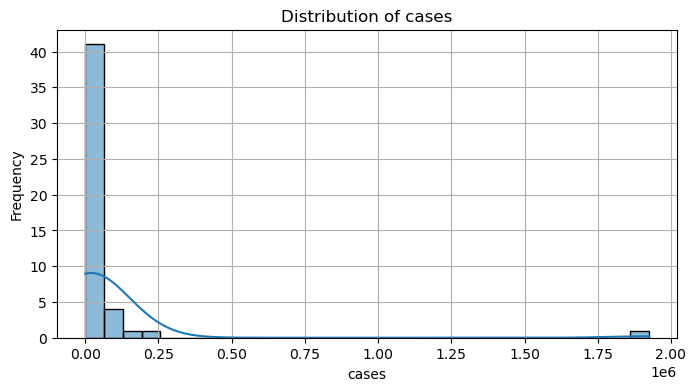

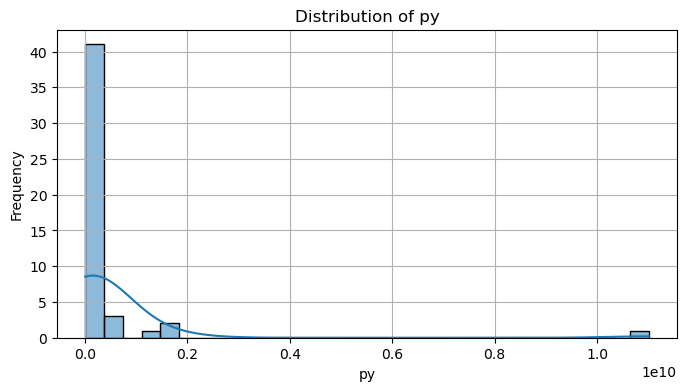

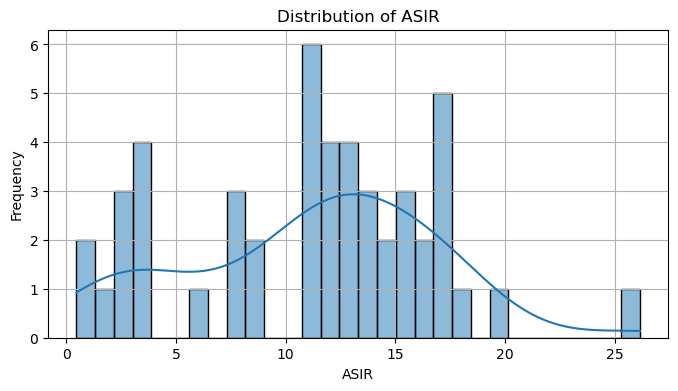

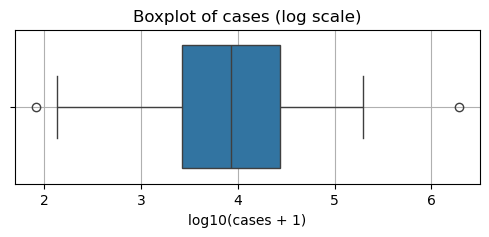

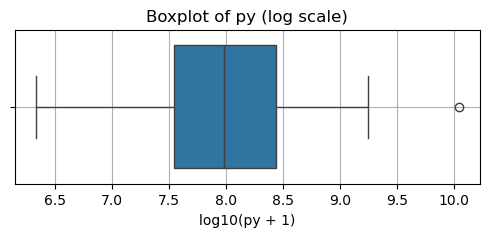

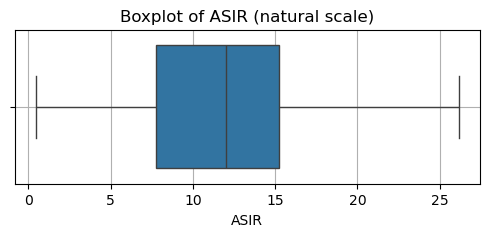


Correlation matrix:


,cases,py,ASIR
cases,1.00,0.99,0.19
py,0.99,1.00,0.16
ASIR,0.19,0.16,1.00


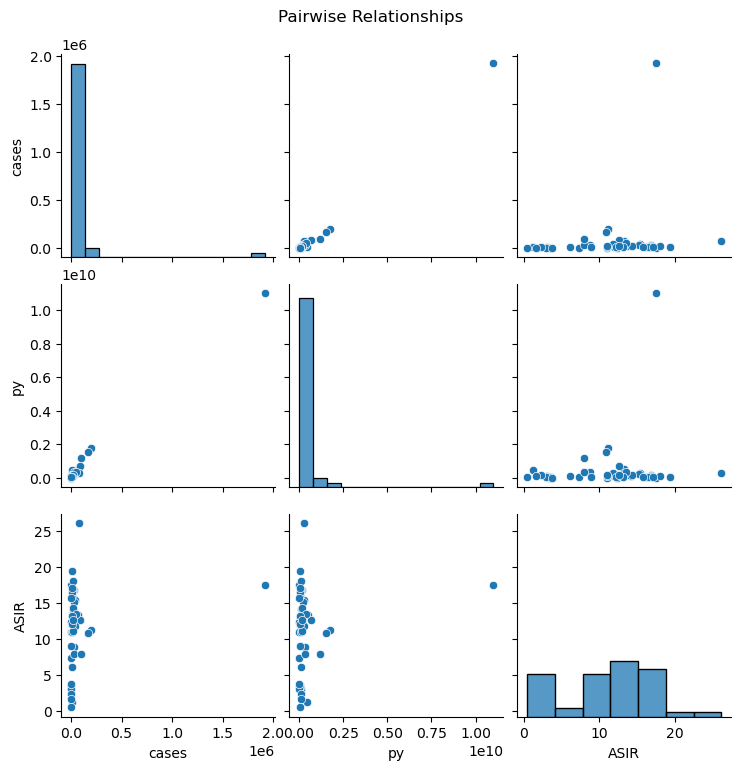


Top 10 countries by ASIR:


,country,ASIR,cases,py
0,Czech Republic,26.16,75268,287754351.00
1,Estonia,19.42,7520,38731397.00
2,Lithuania,18.09,14443,79839256.00
3,Iceland,17.52,1437,8203086.00
4,USA,17.48,1924435,11011402329.00
5,"UK, Wales",17.09,6061,35474380.00
6,Austria,16.90,26407,156291380.00
7,Germany,16.78,17739,105692609.00
8,Latvia,16.60,10857,65395954.00
9,Italy,16.13,7889,48894980.00



Bottom 10 countries by ASIR:


,country,ASIR,cases,py
0,Uganda,0.46,135,29473865.00
1,India,1.23,5722,464659431.00
2,Thailand,1.65,1865,113169115.00
3,Philippines,2.35,3077,130821605.00
4,Kuwait,3.00,384,12797357.00
5,Costa Rica,3.03,2751,90863628.00
6,Ecuador,3.31,1095,33097640.00
7,Bahrain,3.35,230,6871026.00
8,Colombia,3.59,2436,67917296.00
9,Qatar,3.74,81,2166171.00



Top 10 countries by cases:


,country,ASIR,cases,py
0,USA,17.48,1924435,11011402329.00
1,UK,11.22,197998,1765452592.00
2,"UK, England",10.89,167278,1535868163.00
3,Republic of Korea,7.96,94034,1181098329.00
4,Canada,12.65,85177,673469725.00
5,Czech Republic,26.16,75268,287754351.00
6,Australia,13.33,67291,504723819.00
7,The Netherlands,13.51,49461,366153381.00
8,Belarus,15.43,41754,270605085.00
9,Israel,11.81,35375,299454296.00



Bottom 10 countries by cases:


,country,ASIR,cases,py
0,Qatar,3.74,81,2166171.00
1,Uganda,0.46,135,29473865.00
2,Bahrain,3.35,230,6871026.00
3,Kuwait,3.00,384,12797357.00
4,Chile,11.03,614,5568626.00
5,Cyprus,7.33,903,12325350.00
6,Malta,12.36,992,8024124.00
7,Ecuador,3.31,1095,33097640.00
8,Iceland,17.52,1437,8203086.00
9,Thailand,1.65,1865,113169115.00



Country value counts:


country
Argentina               1
Australia               1
Austria                 1
Bahrain                 1
Belarus                 1
Canada                  1
Chile                   1
China                   1
Colombia                1
Costa Rica              1
Croatia                 1
Cyprus                  1
Czech Republic          1
Denmark                 1
Ecuador                 1
Estonia                 1
France                  1
Germany                 1
Iceland                 1
India                   1
Ireland                 1
Israel                  1
Italy                   1
Japan                   1
Kuwait                  1
Latvia                  1
Lithuania               1
Malta                   1
New Zealand             1
Norway                  1
Philippines             1
Poland                  1
Puerto Rico             1
Qatar                   1
Republic of Korea       1
Slovenia                1
Spain                   1
Switzerland             1
Thai

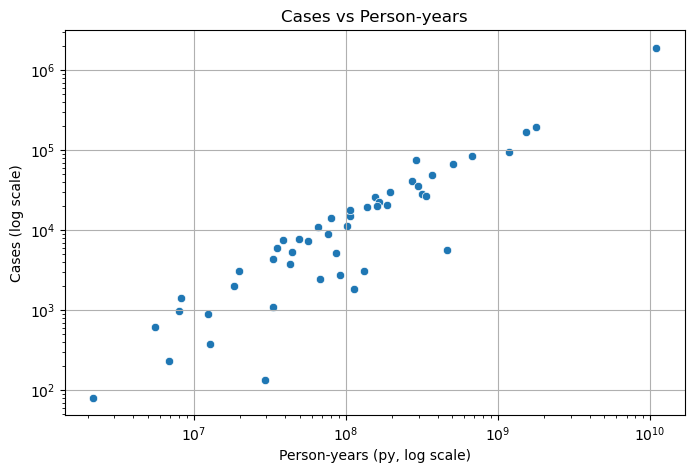

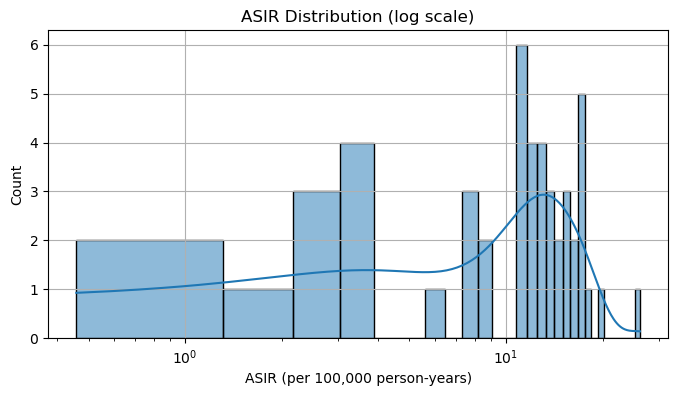

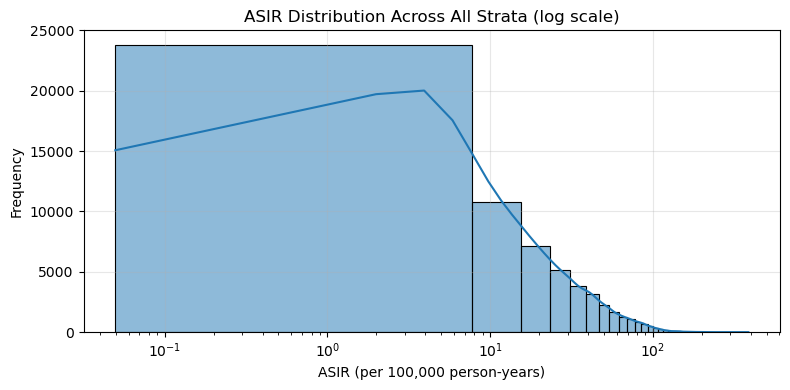


ASIR Summary Statistics (n=63,200 strata):
  Min:    0.05
  Median: 13.10
  Max:    386.60
  Range:  7768.3-fold


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Variable Distributions and EDA for country_aggregated_df ---

# Ensure 'py' is displayed as float with two decimals
pd.set_option('display.float_format', '{:.2f}'.format)

# 1. Basic info and summary statistics
print("DataFrame Info:")
country_aggregated_df.info()
print("\nSummary statistics:")
display(country_aggregated_df.describe())

# 2. Check for missing values
print("\nMissing values per column:")
display(country_aggregated_df.isnull().sum())

# 3. Distribution plots for numerical columns
num_cols = ['cases', 'py', 'ASIR']
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(country_aggregated_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# 4. Boxplots for outlier detection (log scale for 'cases' and 'py', natural scale for 'ASIR')
for col in num_cols:
    plt.figure(figsize=(6, 2))
    if col in ['cases', 'py']:
        sns.boxplot(x=np.log10(country_aggregated_df[col] + 1))  # log10 scale, add 1 to avoid log(0)
        plt.xlabel(f'log10({col} + 1)')
        plt.title(f'Boxplot of {col} (log scale)')
    else:
        sns.boxplot(x=country_aggregated_df[col])
        plt.xlabel(col)
        plt.title(f'Boxplot of {col} (natural scale)')
    plt.grid(True)
    plt.show()

# 5. Correlation matrix
print("\nCorrelation matrix:")
display(country_aggregated_df[num_cols].corr())

# 6. Pairplot for relationships
sns.pairplot(country_aggregated_df[num_cols])
plt.suptitle('Pairwise Relationships', y=1.02)
plt.show()

# 7. Top and bottom countries by ASIR
print("\nTop 10 countries by ASIR:")
display(country_aggregated_df.nlargest(10, 'ASIR')[['country', 'ASIR', 'cases', 'py']].reset_index(drop=True))
print("\nBottom 10 countries by ASIR:")
display(country_aggregated_df.nsmallest(10, 'ASIR')[['country', 'ASIR', 'cases', 'py']].reset_index(drop=True))

# 8. Top and bottom countries by cases
print("\nTop 10 countries by cases:")
display(country_aggregated_df.nlargest(10, 'cases')[['country', 'ASIR', 'cases', 'py']].reset_index(drop=True))
print("\nBottom 10 countries by cases:")
display(country_aggregated_df.nsmallest(10, 'cases')[['country', 'ASIR', 'cases', 'py']].reset_index(drop=True))

# 9. Value counts for country
print("\nCountry value counts:")
display(country_aggregated_df['country'].value_counts())

# 10. Scatter plot: cases vs py (log scale)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=country_aggregated_df, x='py', y='cases')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Person-years (py, log scale)')
plt.ylabel('Cases (log scale)')
plt.title('Cases vs Person-years')
plt.grid(True)
plt.show()

# 11. ASIR distribution (log scale)
plt.figure(figsize=(8, 4))
sns.histplot(country_aggregated_df['ASIR'], kde=True, bins=30)
plt.xscale('log')
plt.title('ASIR Distribution (log scale)')
plt.xlabel('ASIR (per 100,000 person-years)')
plt.grid(True)
plt.show()

# 12. ASIR distribution (log scale) 
# Use the full dataset to capture stratum-level variation
plt.figure(figsize=(8, 4))

# Compute ASIR for each observation (registry-year-age-sex stratum)
colon_cancer_full['ASIR_stratum'] = (colon_cancer_full['cases'] / colon_cancer_full['py']) * 100000

# Filter out invalid values (zero/negative py, infinite ASIR)
valid_asir = colon_cancer_full['ASIR_stratum'].replace([np.inf, -np.inf], np.nan).dropna()
valid_asir = valid_asir[valid_asir > 0]  # Exclude zeros for log scale

sns.histplot(valid_asir, kde=True, bins=50)
plt.xscale('log')
plt.title('ASIR Distribution Across All Strata (log scale)')
plt.xlabel('ASIR (per 100,000 person-years)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nASIR Summary Statistics (n={len(valid_asir):,} strata):")
print(f"  Min:    {valid_asir.min():.2f}")
print(f"  Median: {valid_asir.median():.2f}")
print(f"  Max:    {valid_asir.max():.2f}")
print(f"  Range:  {valid_asir.max() / valid_asir.min():.1f}-fold")

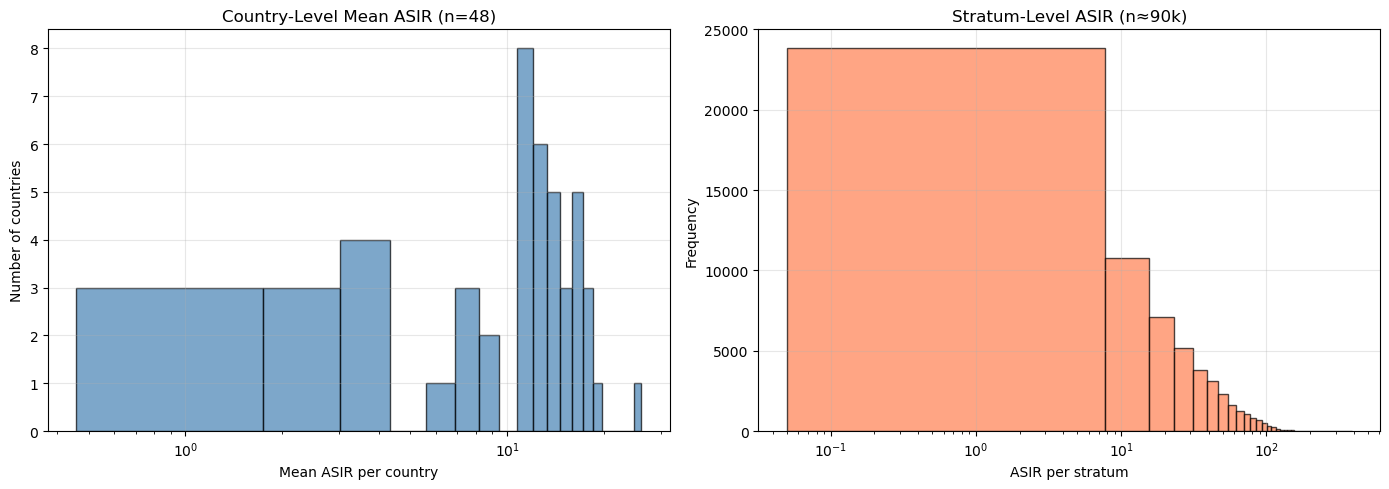

In [10]:
# 13. Side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Country-level means (current approach)
axes[0].hist(country_aggregated_df['ASIR'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xscale('log')
axes[0].set_title('Country-Level Mean ASIR (n=48)')
axes[0].set_xlabel('Mean ASIR per country')
axes[0].set_ylabel('Number of countries')
axes[0].grid(True, alpha=0.3)

# Right: Stratum-level ASIR (corrected approach)
axes[1].hist(valid_asir, bins=50, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xscale('log')
axes[1].set_title('Stratum-Level ASIR (n≈90k)')
axes[1].set_xlabel('ASIR per stratum')
axes[1].set_ylabel('Frequency')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [2]:
import matplotlib.pyplot as plt

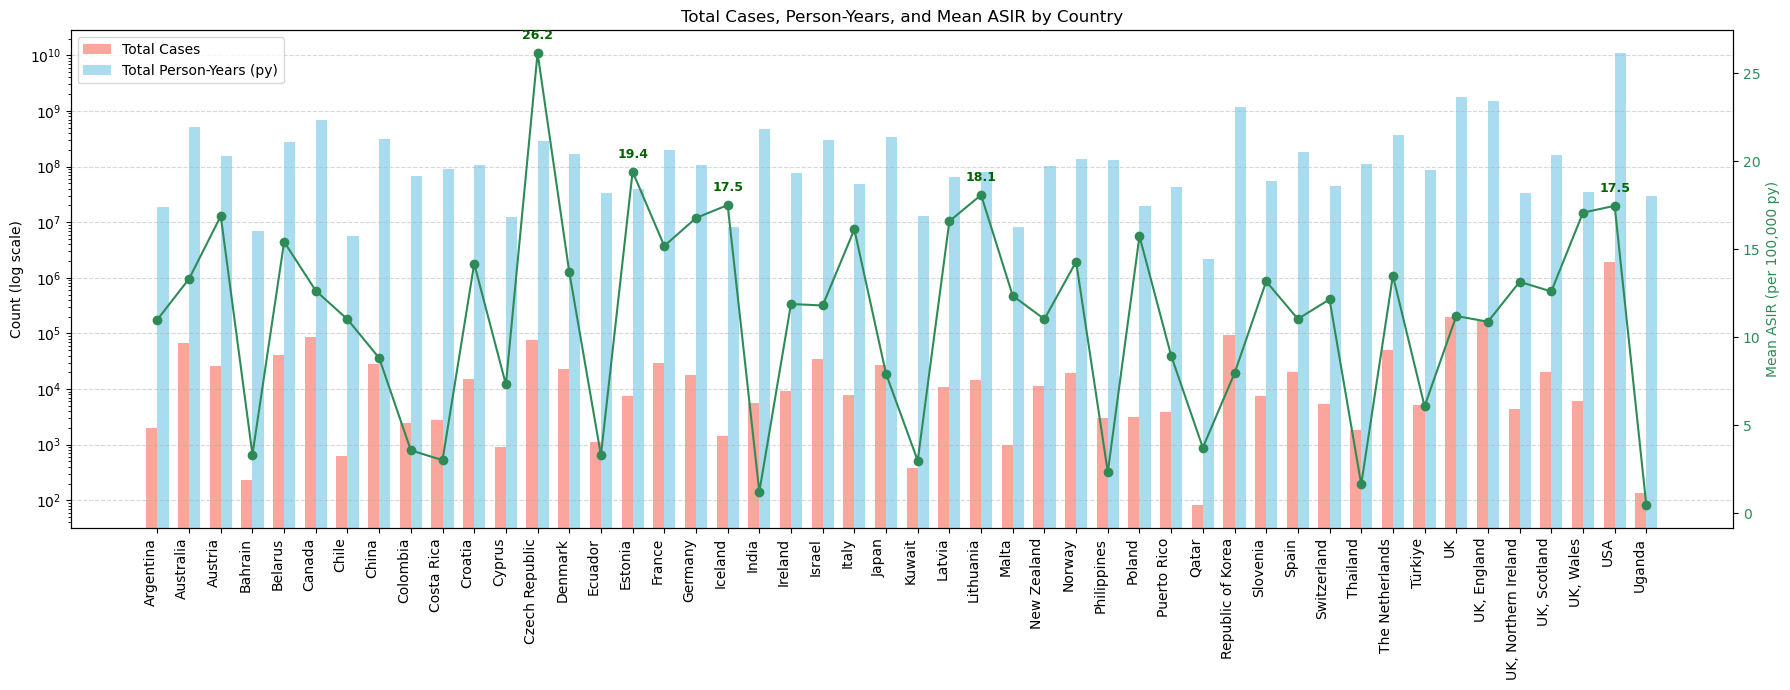

Top 10 Countries by ASIR (Exact Values):
--------------------------------------------------------------------------------
 1. Czech Republic        ASIR:  26.16  Cases:   75,268  Person-years:  287,754,351
 2. Estonia               ASIR:  19.42  Cases:    7,520  Person-years:   38,731,397
 3. Lithuania             ASIR:  18.09  Cases:   14,443  Person-years:   79,839,256
 4. Iceland               ASIR:  17.52  Cases:    1,437  Person-years:    8,203,086
 5. USA                   ASIR:  17.48  Cases: 1,924,435  Person-years: 11,011,402,329
 6. UK, Wales             ASIR:  17.09  Cases:    6,061  Person-years:   35,474,380
 7. Austria               ASIR:  16.90  Cases:   26,407  Person-years:  156,291,380
 8. Germany               ASIR:  16.78  Cases:   17,739  Person-years:  105,692,609
 9. Latvia                ASIR:  16.60  Cases:   10,857  Person-years:   65,395,954
10. Italy                 ASIR:  16.13  Cases:    7,889  Person-years:   48,894,980
-----------------------------------

,country,ASIR,cases,py
0,Czech Republic,26.16,75268,287754351.00
1,Estonia,19.42,7520,38731397.00
2,Lithuania,18.09,14443,79839256.00
3,Iceland,17.52,1437,8203086.00
4,USA,17.48,1924435,11011402329.00
5,"UK, Wales",17.09,6061,35474380.00
6,Austria,16.90,26407,156291380.00
7,Germany,16.78,17739,105692609.00
8,Latvia,16.60,10857,65395954.00
9,Italy,16.13,7889,48894980.00


In [17]:
# 14. Total Cases, Person-Years, and Mean ASIR by Country

# Prepare data
countries = country_aggregated_df['country']
x = np.arange(len(countries))
width = 0.35  # width of the bars

fig, ax1 = plt.subplots(figsize=(18, 7))

# Bar plots for Total Cases and Total Person-Years (log scale)
bar1 = ax1.bar(x - width/2, country_aggregated_df['cases'], width, label='Total Cases', color='salmon', alpha=0.7)
bar2 = ax1.bar(x + width/2, country_aggregated_df['py'], width, label='Total Person-Years (py)', color='skyblue', alpha=0.7)
ax1.set_yscale('log')
ax1.set_ylabel('Count (log scale)')
ax1.set_xticks(x)
ax1.set_xticklabels(countries, rotation=90, ha='right')
ax1.legend(loc='upper left')

# Secondary axis for Mean ASIR
ax2 = ax1.twinx()
line = ax2.plot(x, country_aggregated_df['ASIR'], color='seagreen', marker='o', label='Mean ASIR (per 100,000 py)')
ax2.set_ylabel('Mean ASIR (per 100,000 py)', color='seagreen')
ax2.tick_params(axis='y', labelcolor='seagreen')

# ADD DATA LABELS (only for top 5 countries to avoid clutter)
top5_idx = country_aggregated_df.nlargest(5, 'ASIR').index
for idx in top5_idx:
    i = list(country_aggregated_df.index).index(idx)
    ax2.annotate(
        f'{country_aggregated_df.loc[idx, "ASIR"]:.1f}',  # ASIR value with 1 decimal
        xy=(i, country_aggregated_df.loc[idx, 'ASIR']),
        xytext=(0, 10),  # Offset 10 points above
        textcoords='offset points',
        ha='center',
        fontsize=9,
        color='darkgreen',
        weight='bold'
    )

# Add grid and title
ax1.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.title('Total Cases, Person-Years, and Mean ASIR by Country')
plt.tight_layout()
plt.show()

# Get exact top 10 countries by ASIR with all details
top10_exact = country_aggregated_df.nlargest(10, 'ASIR')[['country', 'ASIR', 'cases', 'py']].reset_index(drop=True)

print("Top 10 Countries by ASIR (Exact Values):")
print("-" * 80)
for idx, row in top10_exact.iterrows():
    print(f"{idx+1:2d}. {row['country']:20s}  ASIR: {row['ASIR']:6.2f}  "
          f"Cases: {row['cases']:8,.0f}  Person-years: {row['py']:12,.0f}")
print("-" * 80)

# Also display as DataFrame
display(top10_exact)

In [7]:
# Incidence rates per country (1978-2017) aggregated at a finer level
# Aggregate data to country level, grouping by country, year, age-group, sex label, region and HDI category
country_aggregated_df2 = colon_cancer_full.groupby(['country', 'year', 'age_group', 'sex_label', 'region', 'hdi_category']).agg({
    'cases': 'sum',
    'py': 'sum'
}).reset_index()

# Calculate ASIR per 100,000 person-years at the country level
# Add a small number to 'py' to avoid division by zero
country_aggregated_df2['ASIR'] = (country_aggregated_df2['cases'] / (country_aggregated_df2['py'])) * 100000

# Display the first few rows of the country-aggregated DataFrame
display(country_aggregated_df2.head())

# Display the shape of the country-aggregated DataFrame
print("\nShape of the country-aggregated DataFrame:", country_aggregated_df2.shape)

,country,year,age_group,sex_label,region,hdi_category,cases,py,ASIR
0,Argentina,2003,Old,Female,Latin America and the Caribbean,Very High,41,179203.00,22.88
1,Argentina,2003,Old,Male,Latin America and the Caribbean,Very High,62,152454.00,40.67
2,Argentina,2003,Young,Female,Latin America and the Caribbean,Very High,8,399309.00,2.00
3,Argentina,2003,Young,Male,Latin America and the Caribbean,Very High,14,385582.00,3.63
4,Argentina,2004,Old,Female,Latin America and the Caribbean,Very High,27,182895.00,14.76



Shape of the country-aggregated DataFrame: (5976, 9)


In [8]:
# Check for missing values (NaN) in the 'ASIR' column
missing_asir = country_aggregated_df2['ASIR'].isnull().sum()
print(f"Number of missing values (NaN) in ASIR column: {missing_asir}")

# Check for infinite values in the 'ASIR' column
infinite_asir = np.isinf(country_aggregated_df2['ASIR']).sum()
print(f"Number of infinite values in ASIR column: {infinite_asir}")

# Check for any NaN or infinite values in the 'ASIR' column
if missing_asir == 0 and infinite_asir == 0:
    print("\nNo missing, NaN, or infinite values found in the ASIR column.")
else:
    print("\nMissing, NaN, or infinite values found in the ASIR column. Further investigation or handling may be needed.")

# Check for for missing values (NaN) in the 'hdi_category' column
missing_hdi = country_aggregated_df2['hdi_category'].isnull().sum()
print(f"Number of missing values (NaN) in hdi_category column: {missing_hdi}")

Number of missing values (NaN) in ASIR column: 0
Number of infinite values in ASIR column: 0

No missing, NaN, or infinite values found in the ASIR column.
Number of missing values (NaN) in hdi_category column: 0


In [9]:
# Save country_aggregated_df2 as a CSV file to the specified directory
output_path = "data/country_aggregated_df2.csv"
country_aggregated_df2.to_csv(output_path, index=False)
print(f"country_aggregated_df2 saved to {output_path}")

country_aggregated_df2 saved to data/country_aggregated_df2.csv


Descriptive statistics:


,country,year,age_group,sex_label,region,hdi_category,cases,py,ASIR
count,5976,5976.00,5976,5976,5976,5976,5976.00,5976.00,5976.00
unique,48,-,2,2,12,3,-,-,-
top,India,-,Old,Female,Northern Europe,Very High,-,-,-
freq,160,-,2988,2988,1616,5064,-,-,-
mean,-,2000.74,-,-,-,-,516.32,3597880.19,15.05
std,-,10.61,-,-,-,-,3406.24,15125608.50,18.25
min,-,1978.00,-,-,-,-,0.00,7767.00,0.00
25%,-,1993.00,-,-,-,-,12.00,300985.00,1.93
50%,-,2002.00,-,-,-,-,47.00,798223.00,5.07
75%,-,2010.00,-,-,-,-,190.00,1964026.50,24.08



Missing values per column:


country         0
year            0
age_group       0
sex_label       0
region          0
hdi_category    0
cases           0
py              0
ASIR            0
dtype: int64

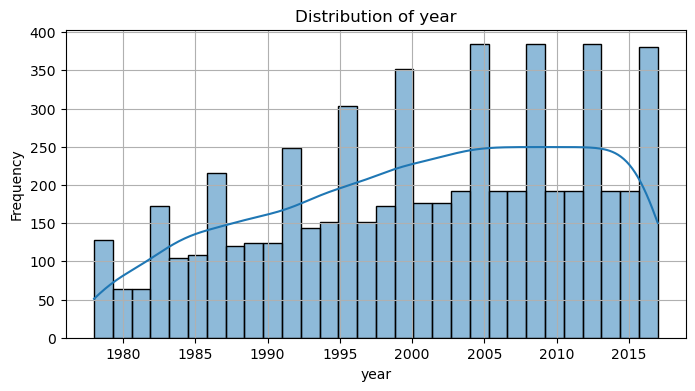

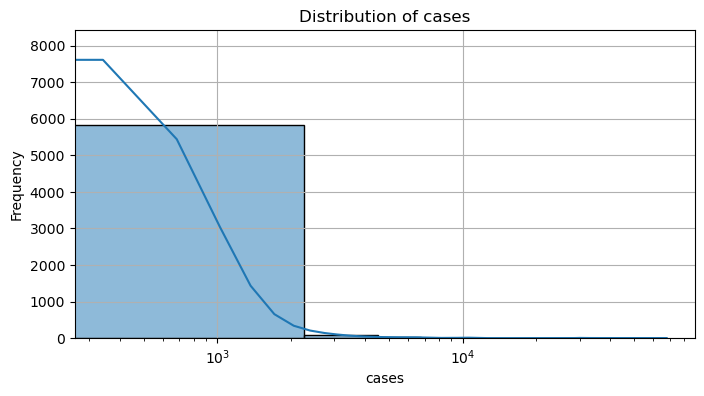

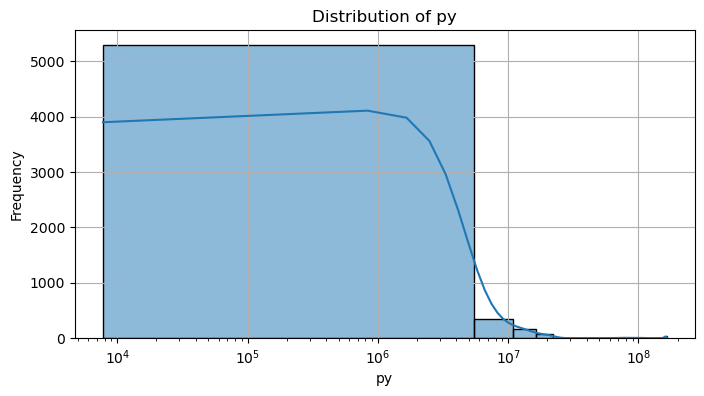

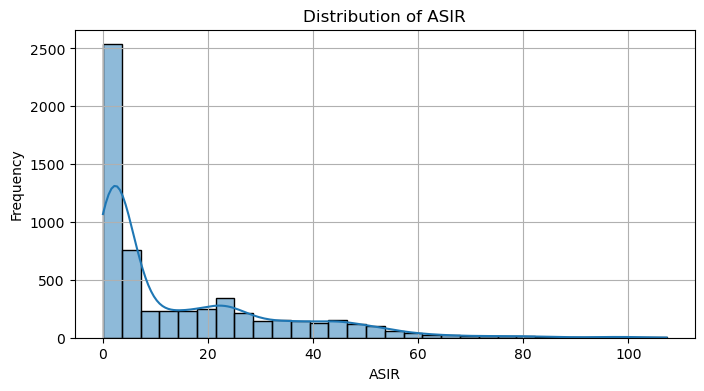

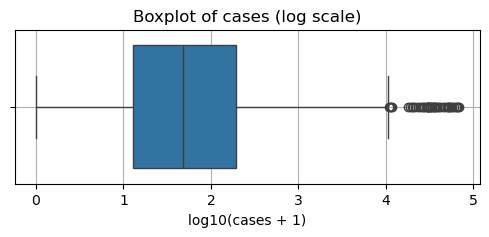

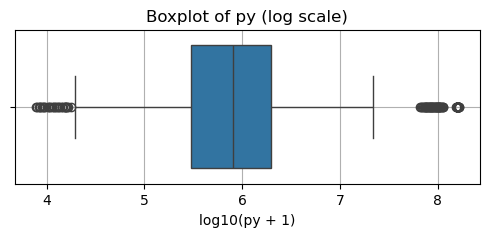

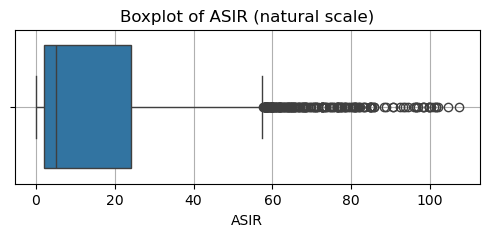


Correlation matrix:


,year,cases,py,ASIR
year,1.00,0.08,0.07,0.13
cases,0.08,1.00,0.59,0.18
py,0.07,0.59,1.00,-0.01
ASIR,0.13,0.18,-0.01,1.00


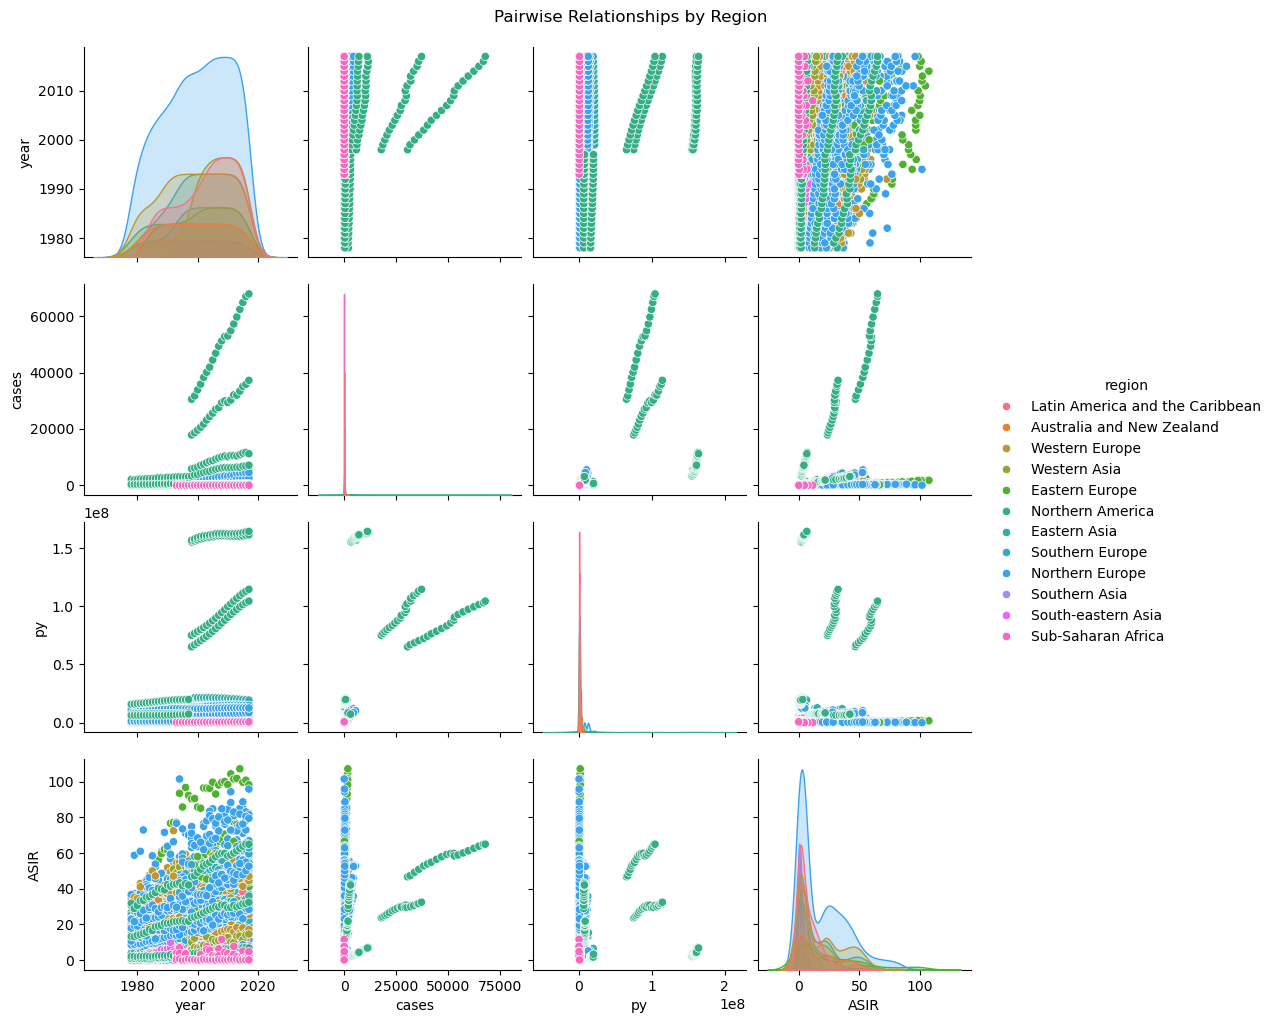


Value counts for 'country':


country
India                   160
UK, England             160
Iceland                 160
Germany                 160
France                  160
Australia               160
Denmark                 160
Norway                  160
Israel                  160
Japan                   160
UK                      160
UK, Scotland            160
Canada                  160
Spain                   160
USA                     160
Switzerland             160
Slovenia                140
New Zealand             140
Latvia                  140
Philippines             140
Thailand                140
Estonia                 140
Czech Republic          140
Belarus                 140
Costa Rica              140
Colombia                140
Ecuador                 132
Croatia                 120
Lithuania               120
Austria                 120
The Netherlands         116
Republic of Korea       100
China                   100
Uganda                  100
UK, Northern Ireland    100
Malta       


Value counts for 'age_group':


age_group
Old      2988
Young    2988
Name: count, dtype: int64


Value counts for 'sex_label':


sex_label
Female    2988
Male      2988
Name: count, dtype: int64


Value counts for 'region':


region
Northern Europe                    1616
Western Europe                      716
Southern Europe                     616
Latin America and the Caribbean     612
Western Asia                        540
Eastern Asia                        360
Eastern Europe                      356
Northern America                    320
Australia and New Zealand           300
South-eastern Asia                  280
Southern Asia                       160
Sub-Saharan Africa                  100
Name: count, dtype: int64


Value counts for 'hdi_category':


hdi_category
Very High    5064
High          652
Medium        260
Name: count, dtype: int64

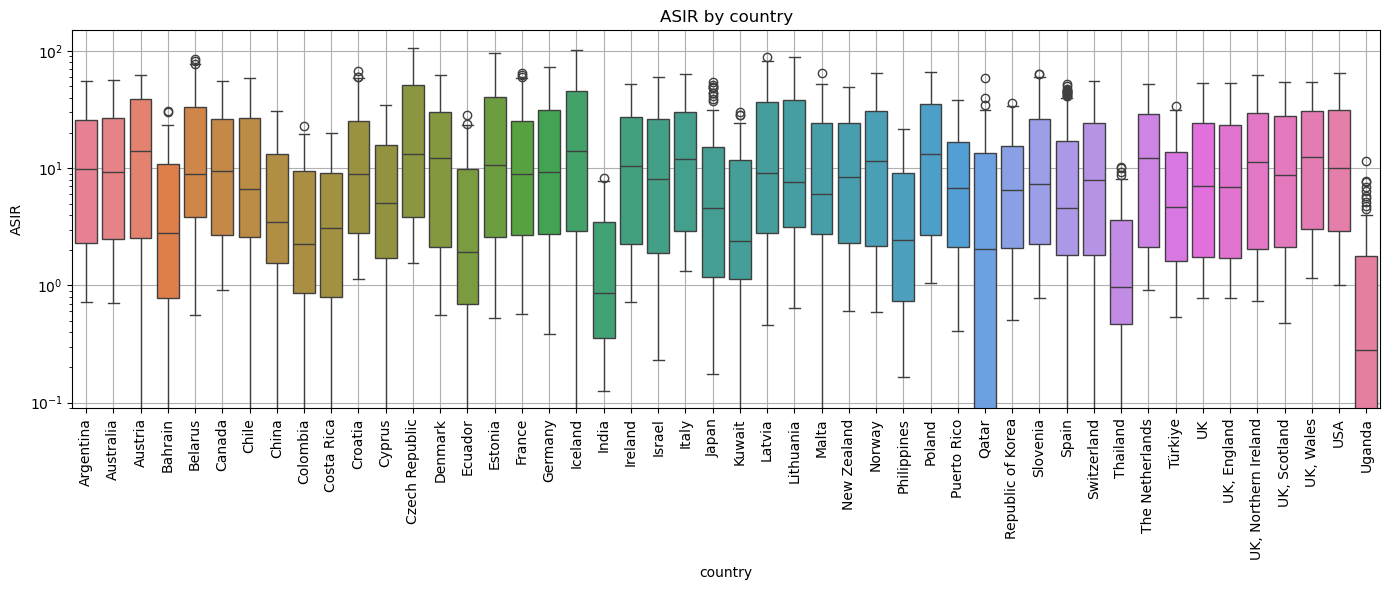

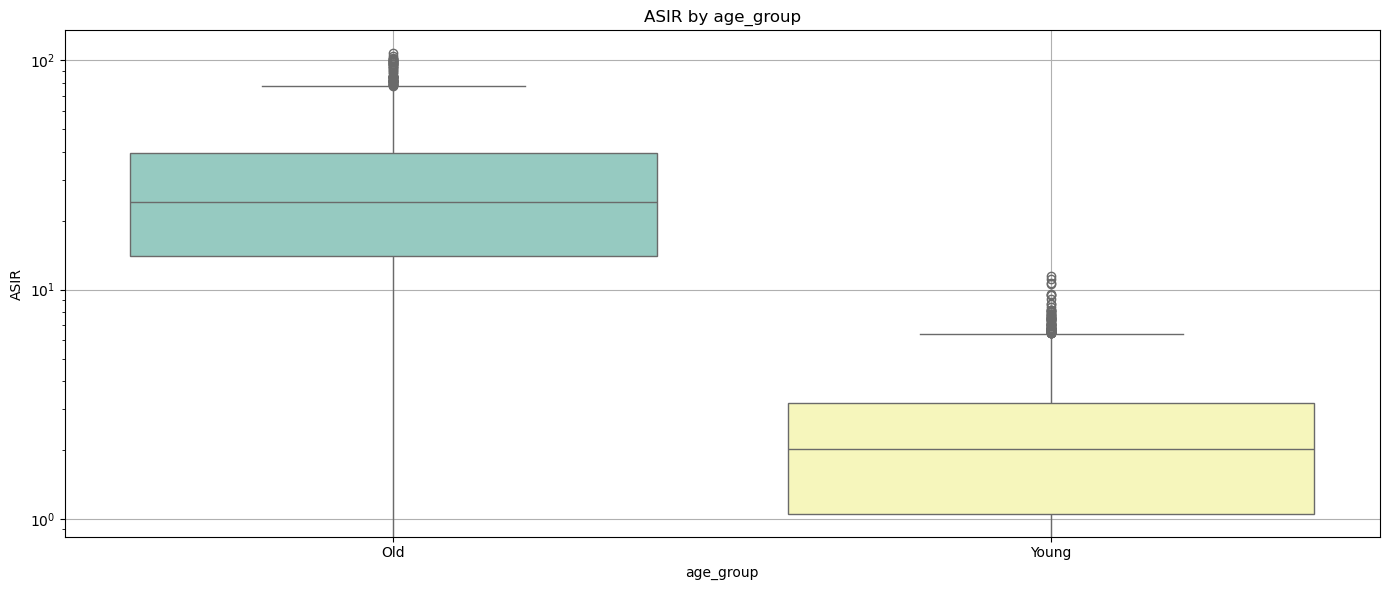

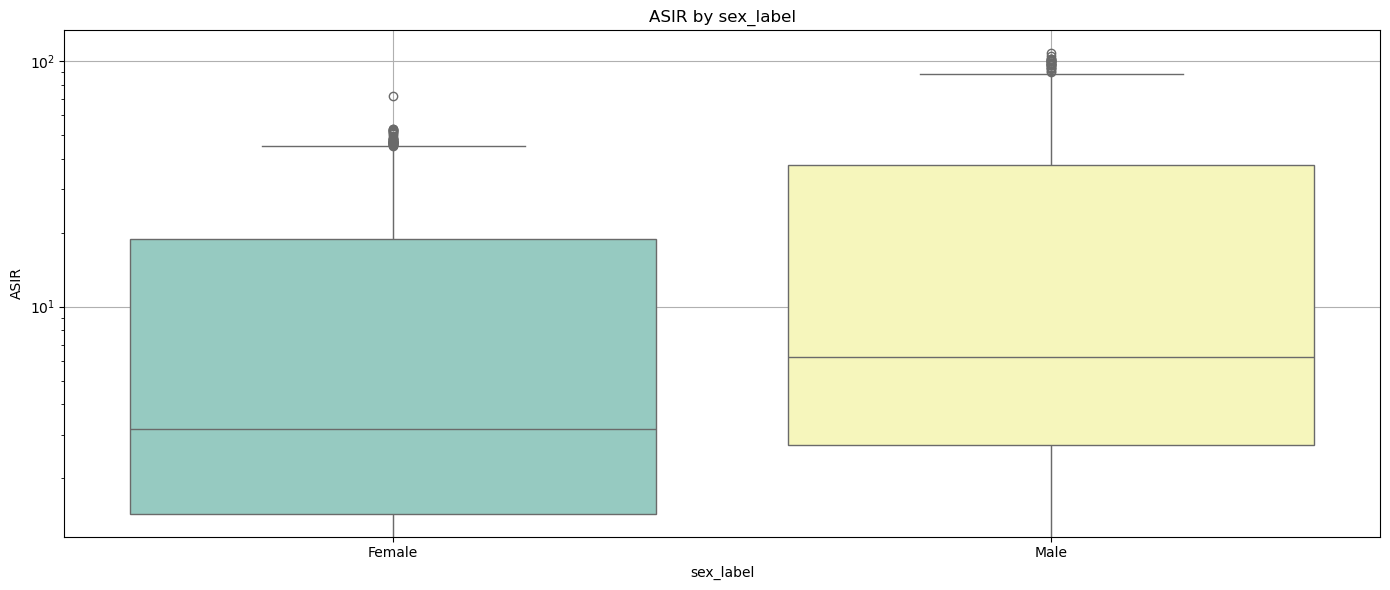

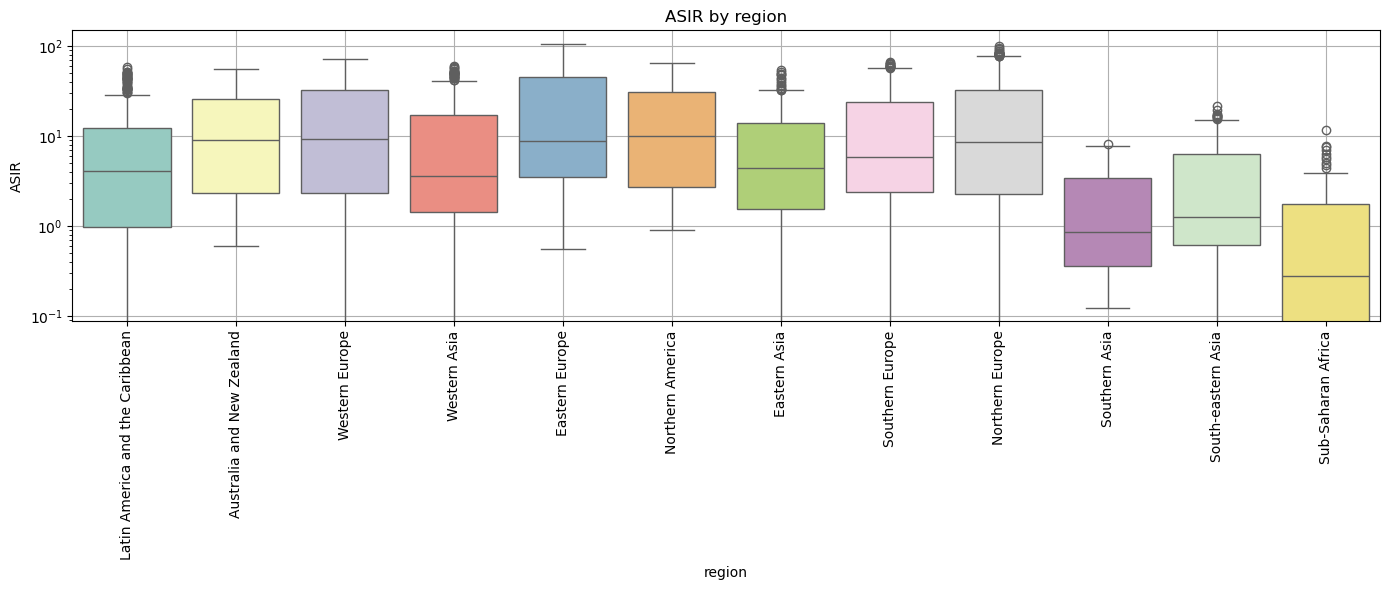

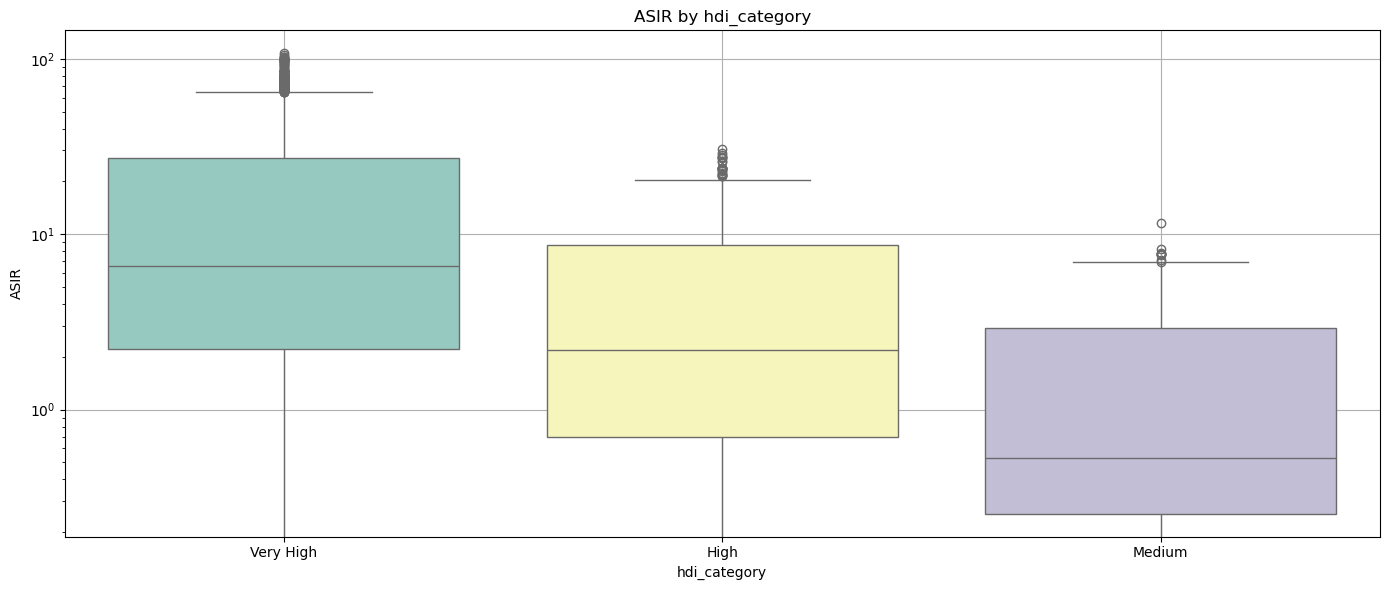

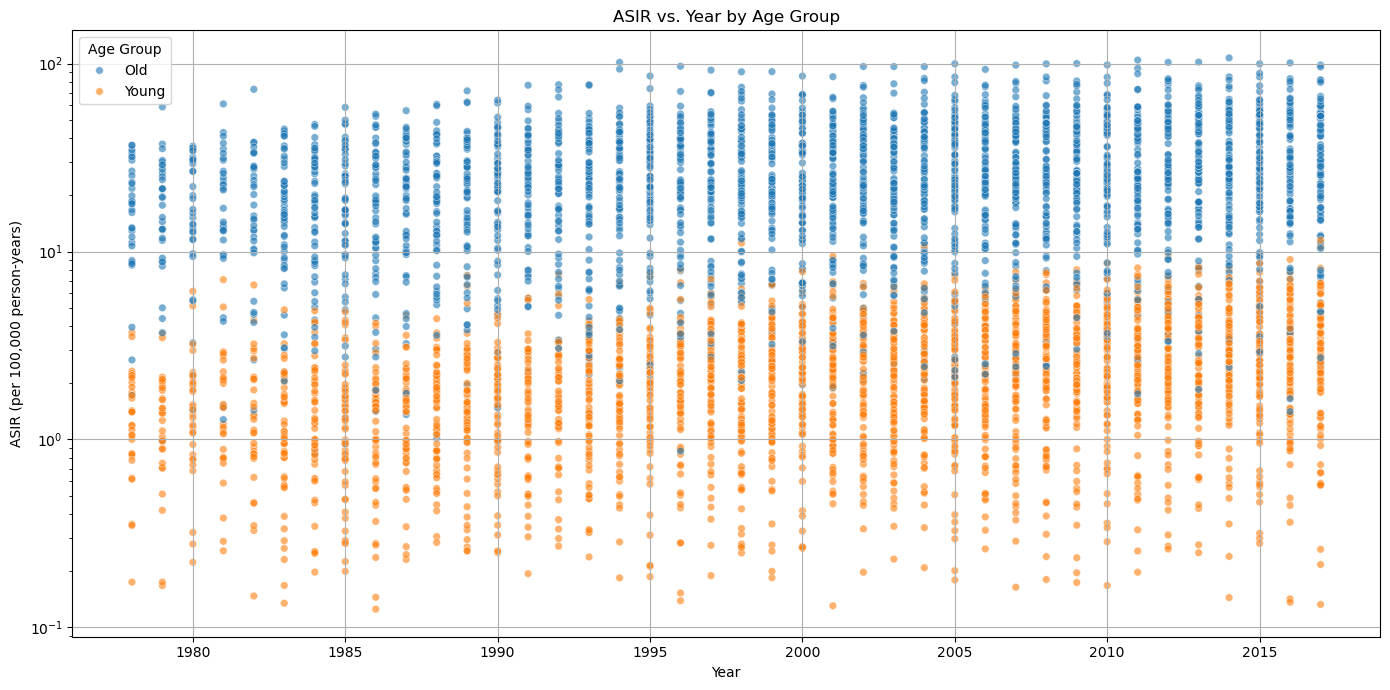

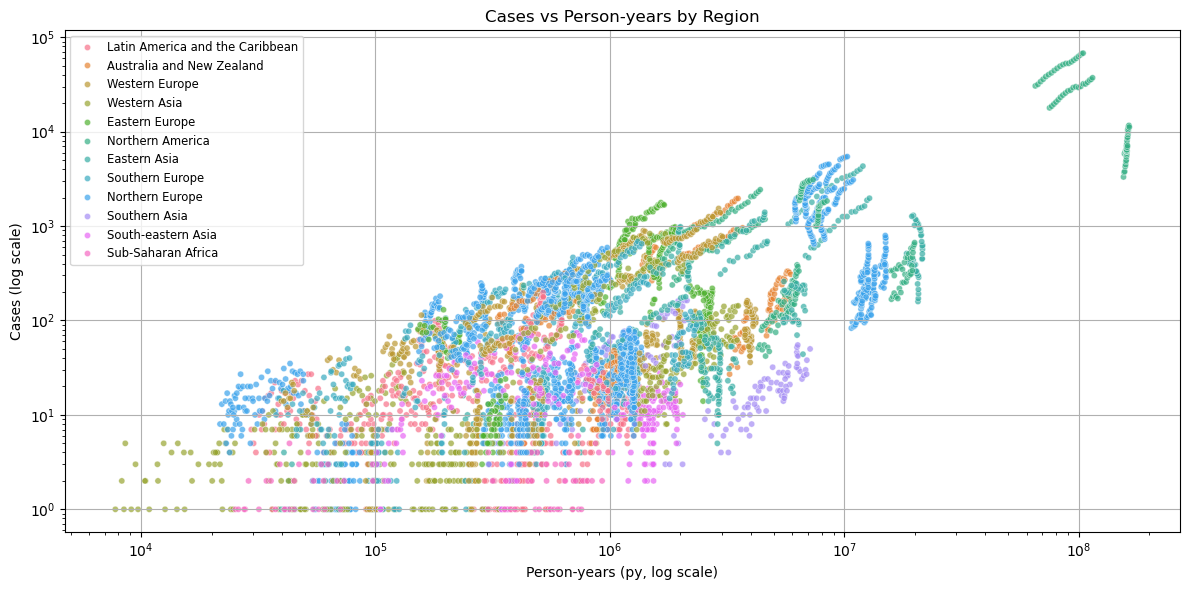

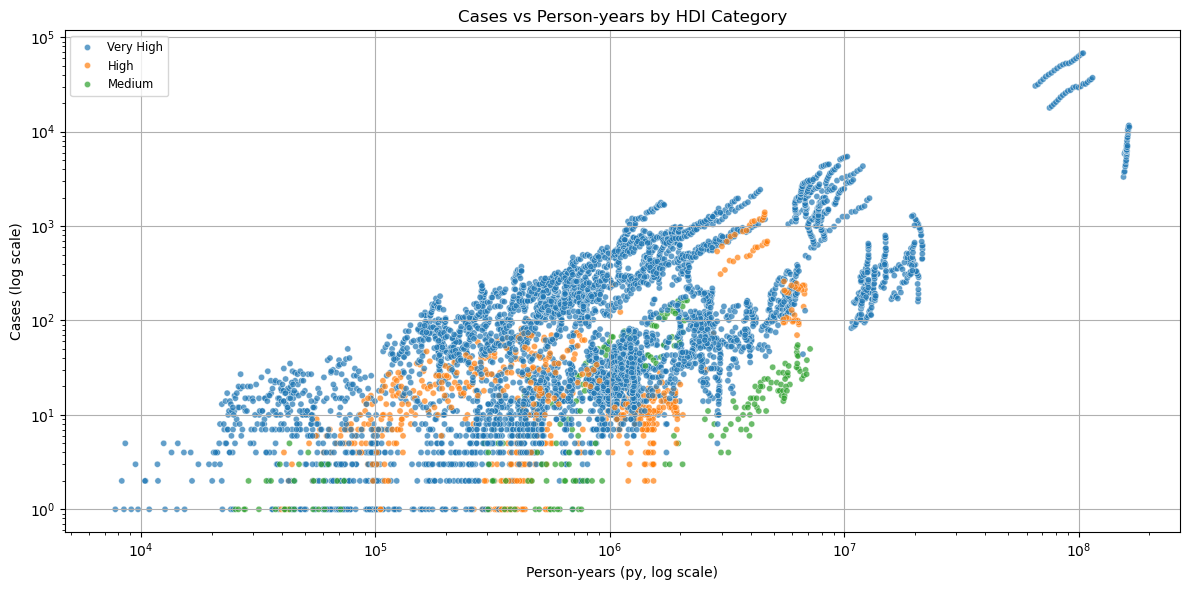

In [10]:
# --- Variable Distributions and EDA for country_aggregated_df2 ---

# 1. Descriptive statistics
print("Descriptive statistics:")
display(country_aggregated_df2.describe(include='all').replace({np.nan: "-"}))

# 2. Check for missing values
print("\nMissing values per column:")
display(country_aggregated_df2.isnull().sum())

# 3. Distribution plots for all numerical columns
numerical_cols = ['year', 'cases', 'py', 'ASIR']
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(country_aggregated_df2[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    if col in ['cases', 'py']:
        plt.xscale('log')
    plt.grid(True)
    plt.show()

# 4. Boxplots for outlier detection
for col in ['cases', 'py', 'ASIR']:
    plt.figure(figsize=(6, 2))
    if col in ['cases', 'py']:
        sns.boxplot(x=np.log10(country_aggregated_df2[col] + 1))
        plt.xlabel(f'log10({col} + 1)')
        plt.title(f'Boxplot of {col} (log scale)')
    else:
        sns.boxplot(x=country_aggregated_df2[col])
        plt.xlabel(col)
        plt.title(f'Boxplot of {col} (natural scale)')
    plt.grid(True)
    plt.show()

# 5. Correlation matrix (numerical columns only)
print("\nCorrelation matrix:")
display(country_aggregated_df2[numerical_cols].corr())

# 6. Pairplot for relationships (numerical + categorical)
sns.pairplot(country_aggregated_df2, vars=numerical_cols, hue='region')
plt.suptitle('Pairwise Relationships by Region', y=1.02)
plt.show()

# 7. Value counts for all categorical variables
categorical_cols = ['country', 'age_group', 'sex_label', 'region', 'hdi_category']
for col in categorical_cols:
    print(f"\nValue counts for '{col}':")
    display(country_aggregated_df2[col].value_counts())

# 8. Boxplot of ASIR by all categorical variables (each category in its own color)
for cat in categorical_cols:
    plt.figure(figsize=(14, 6))
    order_vals = country_aggregated_df2[cat].dropna().unique()
    n_levels_local = len(order_vals)

    # Choose a palette with enough distinct colors
    if n_levels_local <= 12:
        colors_local = sns.color_palette("Set3", n_levels_local)
    else:
        colors_local = sns.color_palette("husl", n_levels_local)

    palette_map_local = dict(zip(order_vals, colors_local))

    sns.boxplot(
        data=country_aggregated_df2,
        x=cat,
        y='ASIR',
        order=order_vals,
        hue=cat,                # assign x variable to hue
        hue_order=order_vals,
        palette=palette_map_local,
        dodge=False,            # avoid side-by-side duplication
        legend=False            # suppress legend as requested
    )
    plt.title(f'ASIR by {cat}')
    plt.yscale('log')
    if n_levels_local > 10:
        plt.xticks(rotation=90)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 9. Scatter Plot of ASIR vs Year (with Age Group)
plt.figure(figsize=(14, 7))
sns.scatterplot(data=country_aggregated_df2, x='year', y='ASIR', hue='age_group', alpha=0.6, s=30) # Increased marker size to 30
plt.title('ASIR vs. Year by Age Group')
plt.xlabel('Year')
plt.ylabel('ASIR (per 100,000 person-years)')
plt.yscale('log') # Set y-axis to log scale
plt.grid(True)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

# 10. Scatter plot: cases vs py (log scale), colored by region and hdi_category
plt.figure(figsize=(12, 6))
sns.scatterplot(data=country_aggregated_df2, x='py', y='cases', hue='region', alpha=0.7, s=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Person-years (py, log scale)')
plt.ylabel('Cases (log scale)')
plt.title('Cases vs Person-years by Region')
plt.grid(True)

plt.legend(fontsize='small', title_fontsize='small')
plt.tight_layout()
plt.show()

# 11. Scatter plot: cases vs py (log scale), colored by hdi_category
plt.figure(figsize=(12, 6))
sns.scatterplot(data=country_aggregated_df2, x='py', y='cases', hue='hdi_category', alpha=0.7, s=20)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Person-years (py, log scale)')
plt.ylabel('Cases (log scale)')
plt.title('Cases vs Person-years by HDI Category')
plt.grid(True)

plt.legend(fontsize='small', title_fontsize='small')
plt.tight_layout()
plt.show()

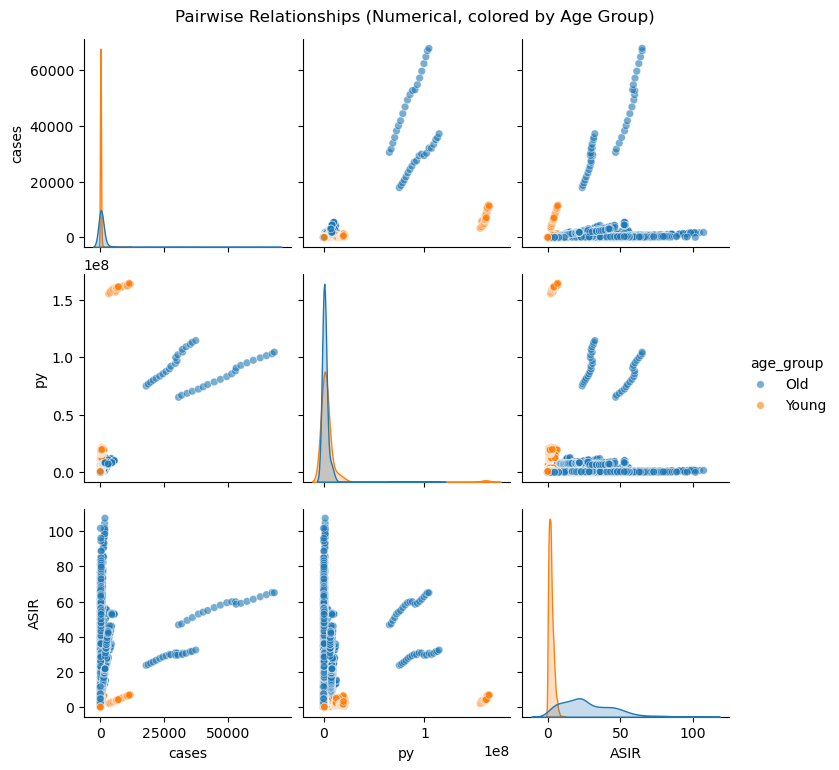

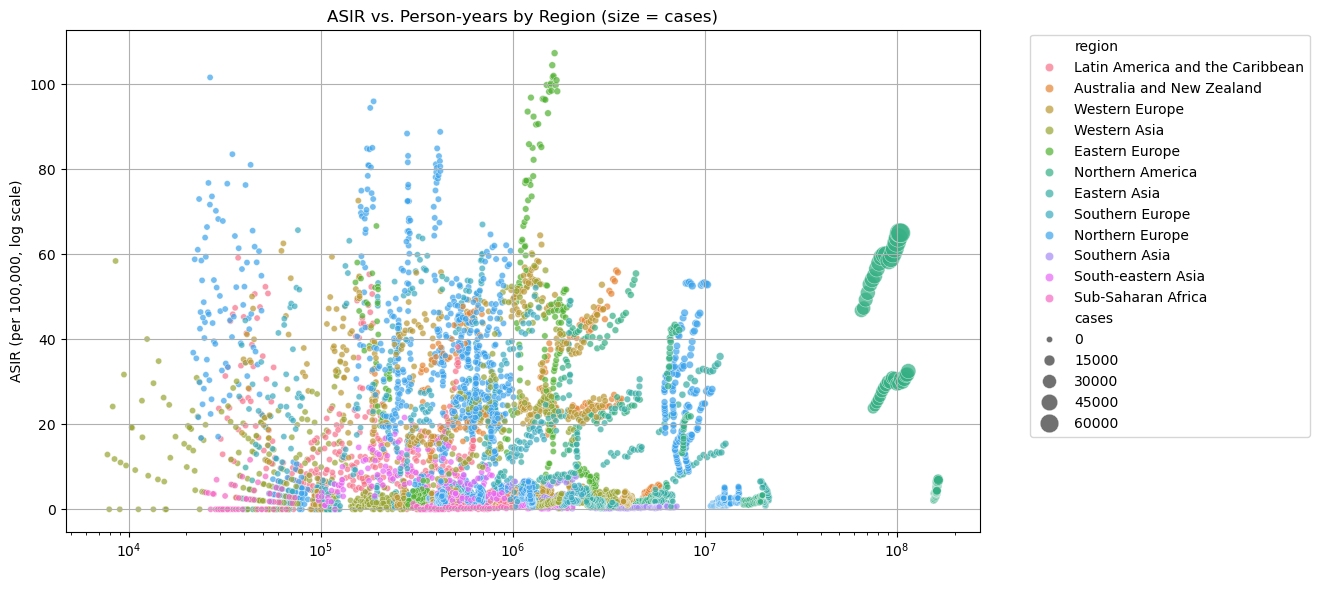

In [11]:
# Scatter plot of ASIR vs. py, colored by Age Group
sns.pairplot(country_aggregated_df2, vars=['cases', 'py', 'ASIR'], hue='age_group', diag_kind='kde', plot_kws={'alpha':0.6, 's':30})
plt.suptitle('Pairwise Relationships (Numerical, colored by Age Group)', y=1.02)
plt.show()

# Scatter plot of ASIR vs. py, colored by region and sized by cases
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=country_aggregated_df2,
    x='py',
    y='ASIR',
    hue='region',
    size='cases',
    alpha=0.7,
    sizes=(20, 200)
)
plt.xscale('log')
plt.xlabel('Person-years (log scale)')
plt.ylabel('ASIR (per 100,000, log scale)')
plt.title('ASIR vs. Person-years by Region (size = cases)')
plt.grid(True)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.3)
plt.show()

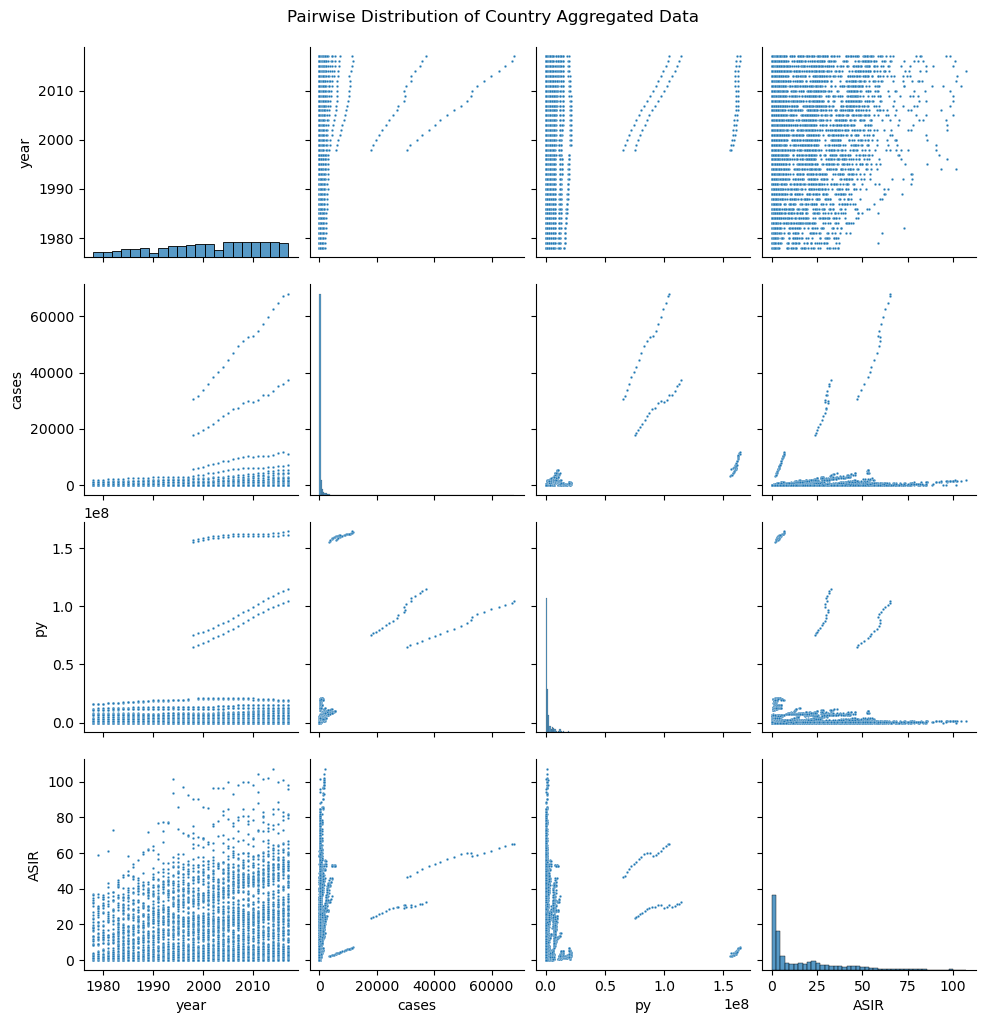

In [12]:
# Create a pairwise distribution plot of the country_aggregated_df DataFrame with smaller markers

sns.pairplot(country_aggregated_df2, plot_kws={'s': 3}) # Reduced marker size
plt.suptitle('Pairwise Distribution of Country Aggregated Data', y=1.02) # Add a title
plt.show()

### `colon_cancer_full` EDA

Basic overview:
Shape: (92326, 12)


,cases,py,year,registry_code,sex_label,country,continent,region,hdi,hdi_category,age_cont,age_group
0,0,60462.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,17.5,Young
1,0,72770.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,22.5,Young
2,0,64952.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,27.5,Young
3,1,45156.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,32.5,Young
4,0,28283.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,37.5,Young
5,0,18323.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,42.5,Young
6,0,12196.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,47.5,Young
7,0,9359.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,52.5,Old
8,0,4810.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,57.5,Old
9,0,4026.0,1993,800002,Male,Uganda,Africa,Sub-Saharan Africa,0.582,Medium,62.5,Old



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92326 entries, 0 to 92325
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   cases          92326 non-null  int64  
 1   py             92326 non-null  float64
 2   year           92326 non-null  int64  
 3   registry_code  92326 non-null  int64  
 4   sex_label      92326 non-null  object 
 5   country        92326 non-null  object 
 6   continent      92326 non-null  object 
 7   region         92326 non-null  object 
 8   hdi            92326 non-null  float64
 9   hdi_category   92326 non-null  object 
 10  age_cont       92326 non-null  float64
 11  age_group      92326 non-null  object 
dtypes: float64(3), int64(3), object(6)
memory usage: 8.5+ MB


,dtype,n_unique,n_missing,missing_pct
cases,int64,1157,0,0.0
py,float64,66864,0,0.0
year,int64,40,0,0.0
registry_code,int64,111,0,0.0
sex_label,object,2,0,0.0
country,object,48,0,0.0
continent,object,6,0,0.0
region,object,12,0,0.0
hdi,float64,44,0,0.0
hdi_category,object,3,0,0.0



Numeric summary:


,count,mean,std,min,25%,50%,75%,max
cases,92326.0,33.420055,219.963030,0.000,0.000,2.000,11.000,6.614000e+03
py,92326.0,232880.575667,880632.311947,102.000,17831.250,48516.500,144703.750,1.140938e+07
year,92326.0,2001.986764,10.298481,1978.000,1995.000,2004.000,2011.000,2.017000e+03
registry_code,92326.0,470471.681217,284067.911140,32007.000,233000.000,410003.000,764002.000,8.400800e+05
hdi,92326.0,0.903556,0.070308,0.582,0.906,0.925,0.938,9.720000e-01
age_cont,92326.0,47.500000,18.708388,17.500,32.500,47.500,62.500,7.750000e+01



Top values for 'sex_label':


sex_label
Male      46163
Female    46163
Name: count, dtype: int64


Top values for 'country':


country
USA                  13520
France                8892
Australia             6110
Spain                 5980
Republic of Korea     4628
China                 3666
Switzerland           3640
UK                    3120
Thailand              2860
India                 2730
Name: count, dtype: int64


Top values for 'continent':


continent
Europe                             42926
Asia                               21372
Northern America                   14560
Oceania                             7020
Latin America and the Caribbean     5798
Africa                               650
Name: count, dtype: int64


Top values for 'region':


region
Western Europe                     17576
Northern America                   14560
Northern Europe                    12584
Southern Europe                    10582
Eastern Asia                       10322
Australia and New Zealand           7020
Latin America and the Caribbean     5148
Western Asia                        5070
South-eastern Asia                  3770
Southern Asia                       2730
Name: count, dtype: int64


Top values for 'hdi_category':


hdi_category
Very High    78572
High         10374
Medium        3380
Name: count, dtype: int64


Top values for 'age_group':


age_group
Young    49714
Old      42612
Name: count, dtype: int64

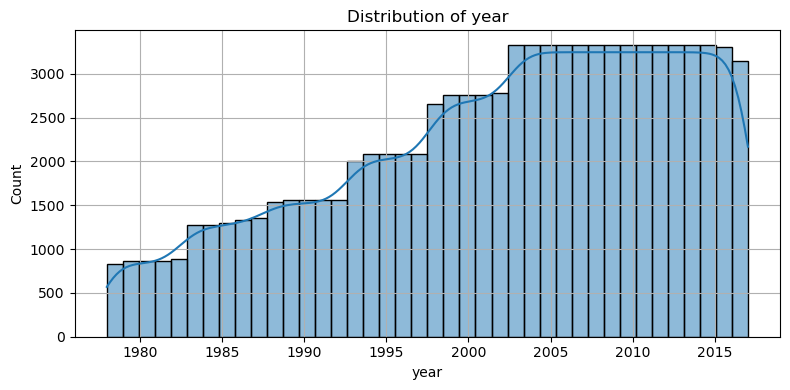

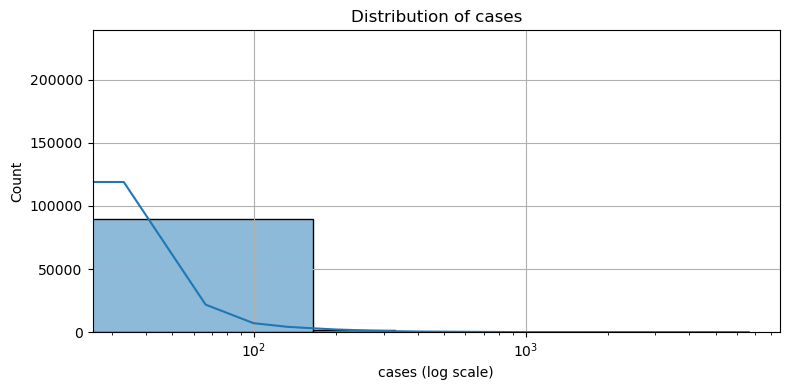

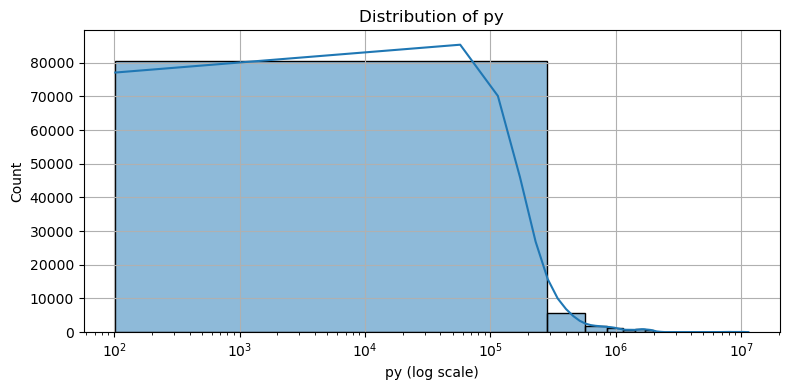

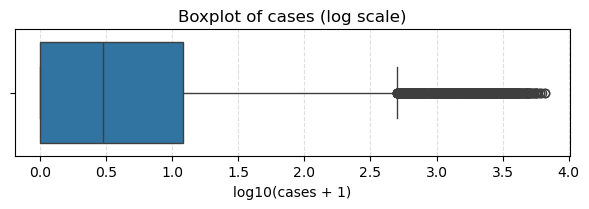

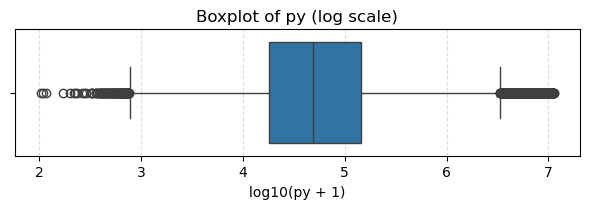


Correlation matrix:


,cases,py,year,registry_code,hdi,age_cont
cases,1.000000,0.577676,6.464114e-02,1.241889e-01,6.480453e-02,1.185191e-01
py,0.577676,1.000000,4.549799e-02,1.875536e-01,7.990317e-02,-6.561128e-02
year,0.064641,0.045498,1.000000e+00,-7.082494e-02,-1.006915e-01,-8.313716e-16
registry_code,0.124189,0.187554,-7.082494e-02,1.000000e+00,1.192471e-01,3.302775e-15
hdi,0.064805,0.079903,-1.006915e-01,1.192471e-01,1.000000e+00,-5.734637e-16
age_cont,0.118519,-0.065611,-8.313716e-16,3.302775e-15,-5.734637e-16,1.000000e+00


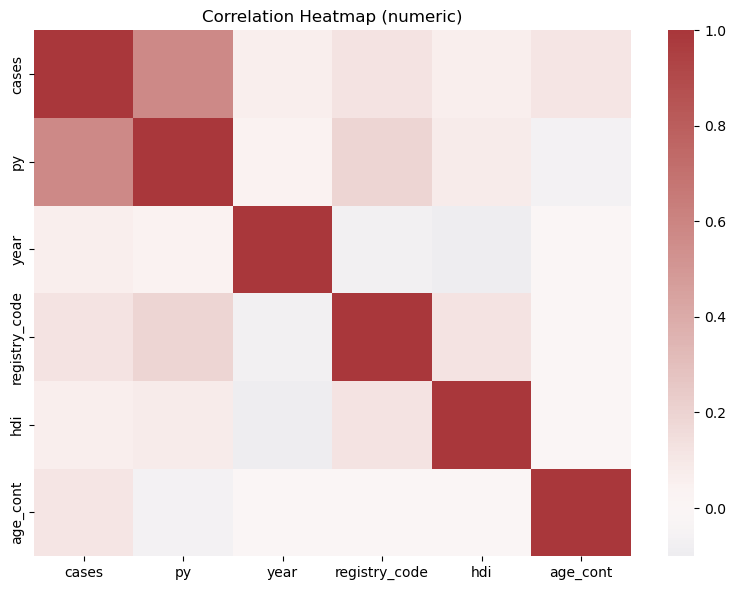

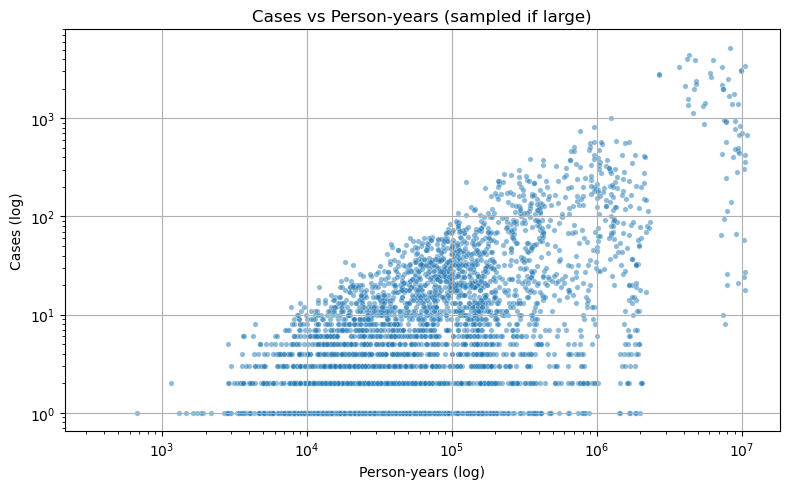

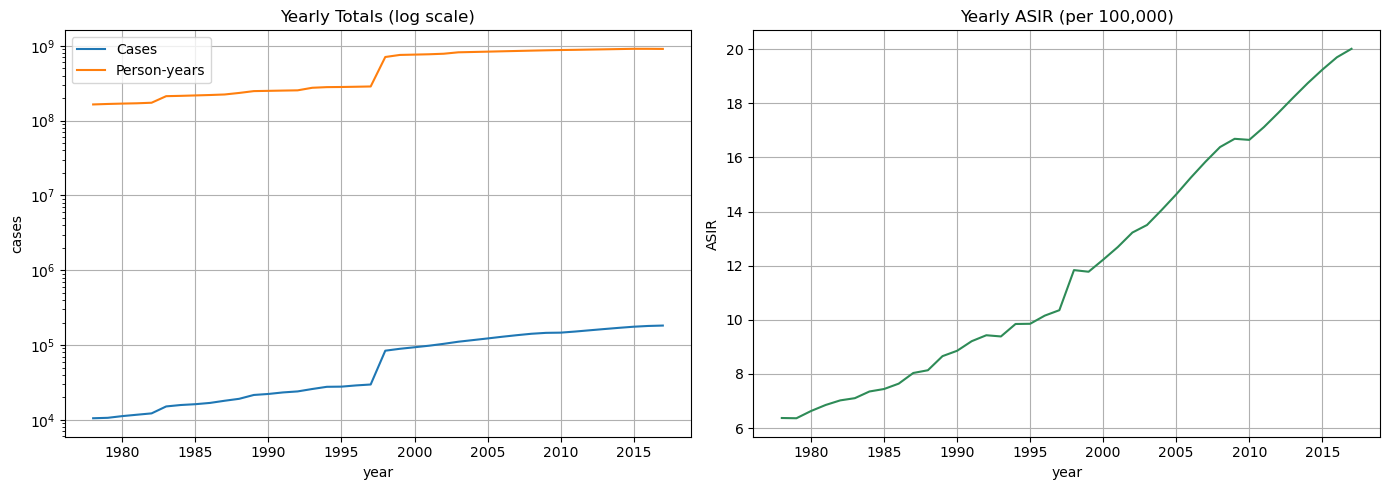

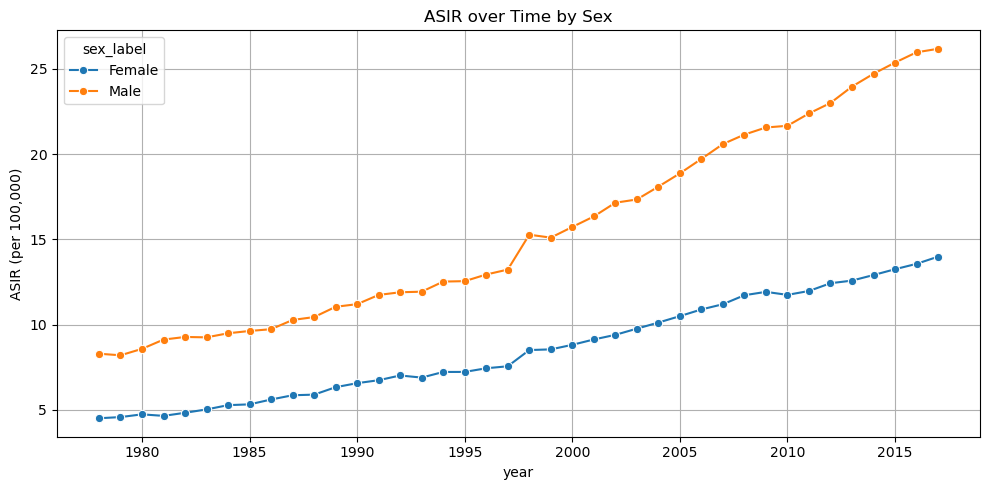

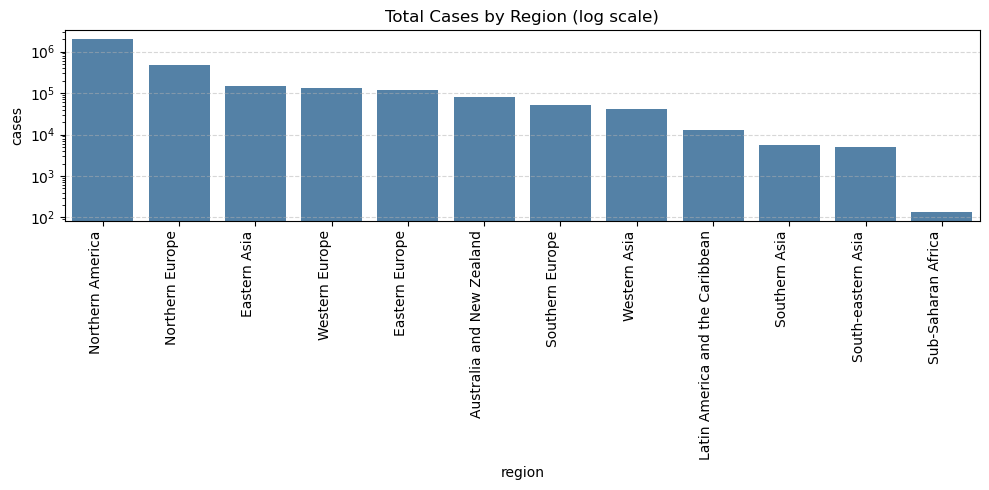

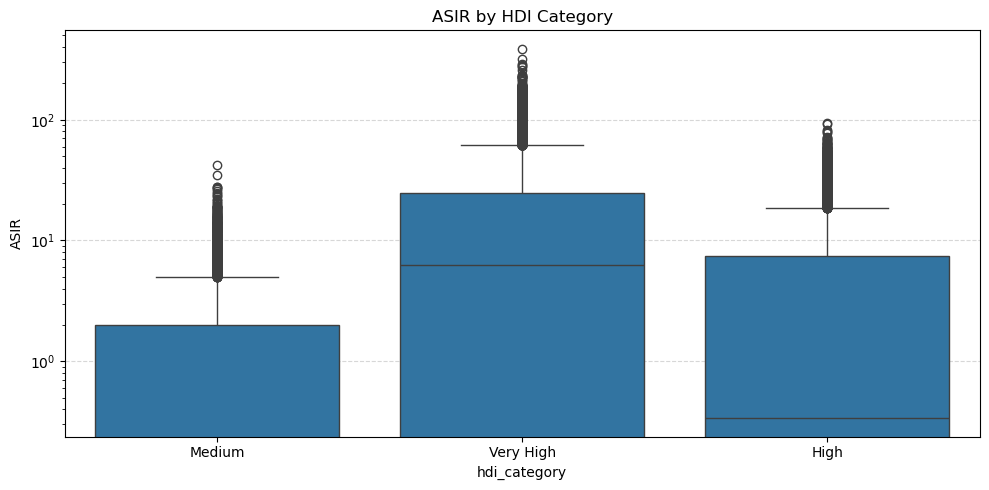


Duplicate rows (entire row match): 0
Duplicate rows by key ['country', 'year', 'age_group', 'sex_label']: 86350


In [8]:
# Imports required for EDA in case this cell runs before others
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# EDA on colon_cancer_full
if 'colon_cancer_full' in globals() and isinstance(colon_cancer_full, pd.DataFrame):
    print("Basic overview:")
    print(f"Shape: {colon_cancer_full.shape}")
    display(colon_cancer_full.head(10))
    print("\nInfo:")
    colon_cancer_full.info()

    # Column-wise summary: dtype, unique, missing
    summary_full = pd.DataFrame({
        'dtype': colon_cancer_full.dtypes,
        'n_unique': colon_cancer_full.nunique(dropna=True),
        'n_missing': colon_cancer_full.isna().sum()
    })
    summary_full['missing_pct'] = (summary_full['n_missing'] / len(colon_cancer_full) * 100).round(2)
    display(summary_full.sort_values('missing_pct', ascending=False))

    # Missing values bar (top 20 with missing)
    missing_full = summary_full[summary_full['n_missing'] > 0].sort_values('missing_pct', ascending=False).head(20)
    if not missing_full.empty:
        plt.figure(figsize=(10, 5))
        sns.barplot(x=missing_full.index, y=missing_full['missing_pct'], color='tomato')
        plt.title('Missing values (%) - Top 20 columns')
        plt.ylabel('% Missing')
        plt.xticks(rotation=90)
        plt.grid(True, axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Numeric and categorical columns
    num_cols_full = colon_cancer_full.select_dtypes(include='number').columns.tolist()
    cat_cols_full = colon_cancer_full.select_dtypes(include=['object', 'category']).columns.tolist()

    print("\nNumeric summary:")
    if num_cols_full:
        display(colon_cancer_full[num_cols_full].describe().T)

    # Top categories for categorical columns
    for col in cat_cols_full:
        print(f"\nTop values for '{col}':")
        display(colon_cancer_full[col].value_counts(dropna=False).head(10))

    # Distributions for common numerical columns (with log where appropriate)
    for col in ['year', 'cases', 'py']:
        if col in colon_cancer_full.columns:
            plt.figure(figsize=(8, 4))
            sns.histplot(colon_cancer_full[col].dropna(), kde=True, bins=40)
            if col in ['cases', 'py']:
                plt.xscale('log')
                plt.xlabel(f'{col} (log scale)')
            else:
                plt.xlabel(col)
            plt.title(f'Distribution of {col}')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # Boxplots for outlier check
    for col in ['cases', 'py']:
        if col in colon_cancer_full.columns:
            plt.figure(figsize=(6, 2.2))
            sns.boxplot(x=np.log10(colon_cancer_full[col].fillna(0) + 1))
            plt.xlabel(f'log10({col} + 1)')
            plt.title(f'Boxplot of {col} (log scale)')
            plt.grid(True, axis='x', linestyle='--', alpha=0.4)
            plt.tight_layout()
            plt.show()

    # Correlation matrix for numeric columns
    if len(num_cols_full) >= 2:
        corr_full = colon_cancer_full[num_cols_full].corr()
        print("\nCorrelation matrix:")
        display(corr_full)
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_full, cmap='vlag', center=0, annot=False)
        plt.title('Correlation Heatmap (numeric)')
        plt.tight_layout()
        plt.show()

    # Simple scatter: cases vs py (log-log)
    if {'cases', 'py'}.issubset(colon_cancer_full.columns):
        scatter_df = colon_cancer_full[['py', 'cases']].dropna()
        if len(scatter_df) > 5000:
            scatter_df = scatter_df.sample(5000, random_state=42)
        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=scatter_df, x='py', y='cases', alpha=0.5, s=15)
        plt.xscale('log'); plt.yscale('log')
        plt.xlabel('Person-years (log)'); plt.ylabel('Cases (log)')
        plt.title('Cases vs Person-years (sampled if large)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Time trends: yearly totals and ASIR
    if {'year', 'cases', 'py'}.issubset(colon_cancer_full.columns):
        annual_full = colon_cancer_full.groupby('year', as_index=False).agg({'cases': 'sum', 'py': 'sum'})
        annual_full['ASIR'] = (annual_full['cases'] / annual_full['py']).replace([np.inf, -np.inf], np.nan) * 100000

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        sns.lineplot(data=annual_full, x='year', y='cases', ax=axes[0], label='Cases')
        sns.lineplot(data=annual_full, x='year', y='py', ax=axes[0], label='Person-years')
        axes[0].set_yscale('log')
        axes[0].set_title('Yearly Totals (log scale)')
        axes[0].grid(True)
        sns.lineplot(data=annual_full, x='year', y='ASIR', ax=axes[1], color='seagreen')
        axes[1].set_title('Yearly ASIR (per 100,000)')
        axes[1].grid(True)
        plt.tight_layout()
        plt.show()

    # ASIR by sex over time (if available)
    if {'year', 'sex_label', 'cases', 'py'}.issubset(colon_cancer_full.columns):
        annual_sex_full = colon_cancer_full.groupby(['year', 'sex_label'], as_index=False).agg({'cases': 'sum', 'py': 'sum'})
        annual_sex_full['ASIR'] = (annual_sex_full['cases'] / annual_sex_full['py']).replace([np.inf, -np.inf], np.nan) * 100000
        plt.figure(figsize=(10, 5))
        sns.lineplot(data=annual_sex_full, x='year', y='ASIR', hue='sex_label', marker='o')
        plt.title('ASIR over Time by Sex')
        plt.ylabel('ASIR (per 100,000)')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Totals by region and ASIR by HDI (if available)
    if 'region' in colon_cancer_full.columns and 'cases' in colon_cancer_full.columns:
        reg_cases = colon_cancer_full.groupby('region', as_index=False)['cases'].sum().sort_values('cases', ascending=False)
        plt.figure(figsize=(10, 5))
        sns.barplot(data=reg_cases, x='region', y='cases', color='steelblue')
        plt.yscale('log')
        plt.title('Total Cases by Region (log scale)')
        plt.xticks(rotation=90, ha='right')
        plt.grid(True, axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    if {'hdi_category', 'cases', 'py'}.issubset(colon_cancer_full.columns):
        tmp_hdi = colon_cancer_full[['hdi_category', 'cases', 'py']].dropna().copy()
        tmp_hdi = tmp_hdi[tmp_hdi['py'] > 0]
        tmp_hdi['ASIR'] = (tmp_hdi['cases'] / tmp_hdi['py']) * 100000
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=tmp_hdi, x='hdi_category', y='ASIR')
        plt.yscale('log')
        plt.title('ASIR by HDI Category')
        plt.grid(True, axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

    # Duplicates check
    dup_total = colon_cancer_full.duplicated().sum()
    print(f"\nDuplicate rows (entire row match): {dup_total}")
    key_cols = ['country', 'year', 'age_group', 'sex_label']
    if set(key_cols).issubset(colon_cancer_full.columns):
        dup_keys = colon_cancer_full.duplicated(subset=key_cols).sum()
        print(f"Duplicate rows by key {key_cols}: {dup_keys}")
else:
    print("colon_cancer_full is not defined. Please run the cell that creates 'colon_cancer_full' first.")

In [ ]:
# Quick rates check (crude per 100k) for under-50 subset
import numpy as np
if 'colon_cancer_u50' in globals():
    dfu = colon_cancer_u50.copy()
    dfu['ASIR_crude'] = (dfu['cases'] / dfu['py']) * 100000.0
    display(dfu[['country' if 'country' in dfu.columns else 'registry_code','year','age_group','sex_label','ASIR_crude']].head())
else:
    print("colon_cancer_u50 not available.")

In [ ]:
# Alignment cell: under-50 subset, standardized age spline (df=4), and decade-scaled year
import pandas as pd, numpy as np
from patsy import dmatrix
from pathlib import Path

root = Path.cwd().resolve().parent if (Path.cwd().name == 'notebooks') else Path.cwd().resolve()
DATA = root / 'data' / 'colon_cancer_full.csv'
df = pd.read_csv(DATA)
if 'age_cont' in df.columns:
    df_u50 = df[df['age_cont'] < 50].reset_index(drop=True)
else:
    df_u50 = df.copy()

# Spline basis with df=4, standardized columns
design = dmatrix("bs(age_cont, df=4, include_intercept=False)", data=df_u50, return_type='dataframe')
B_age = np.asarray(design, dtype=float)
B_mean = B_age.mean(axis=0); B_sd = B_age.std(axis=0); B_sd[B_sd==0] = 1.0
B_age_z = (B_age - B_mean) / B_sd

# Save standardized columns back to dataframe
for j in range(B_age_z.shape[1]):
    df_u50[f'age_spline_z{j+1}'] = B_age_z[:, j]

# Year scaled to decades centered at sample mean
if 'year' in df_u50.columns:
    df_u50['year_decade'] = (df_u50['year'] - df_u50['year'].mean()) / 10.0

print('Aligned subset shape:', df_u50.shape)
df_u50.head(3)